<a href="https://colab.research.google.com/github/hermimimeow/Complete-Python-3-Bootcamp/blob/master/hw11_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 38.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    

In [2]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=b74af0e2a1d20e91e36559d2c7a72041be120eca957254c8119b488e0e73233e
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
import os
import shutil
from tensorflow.keras import utils
import pathlib
import zipfile

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install gdown


In [7]:
training = pd.read_csv('drive/MyDrive/train.csv')
training.head(5)

,Text|Label
0,i would like to know when the national archive...
1,the strongest wind force measured near the cen...
2,i need help because i lost my mother and my fa...
3,i would like to send some informations for me ...
4,in addition it intends to concentrate on promo...


In [8]:
training[['Text', 'Label']] = training['Text|Label'].str.split('|', expand=True)
training

,Text|Label,Text,Label
0,i would like to know when the national archive...,i would like to know when the national archive...,0
1,the strongest wind force measured near the cen...,the strongest wind force measured near the cen...,0
2,i need help because i lost my mother and my fa...,i need help because i lost my mother and my fa...,1
3,i would like to send some informations for me ...,i would like to send some informations for me ...,0
4,in addition it intends to concentrate on promo...,in addition it intends to concentrate on promo...,0
...,...,...,...
21041,good evening how are you please excuse me good...,good evening how are you please excuse me good...,0
21042,asking for information about the news|0,asking for information about the news,0
21043,is there any education related news|0,is there any education related news,0
21044,most of the idps in ingushetia are staying wit...,most of the idps in ingushetia are staying wit...,0


In [9]:
data_train = {
    'Text': ['i would like to know when the national archive...	', 'the strongest wind force measured near the cen...	', 'i need help because i lost my mother and my fa...', 'i would like to send some informations for me ...i would like to send some informations for me ...', 'in addition it intends to concentrate on promo...', '...'],
    'Label': [0, 0, 1, 0, 0]  # And so on for all 21046 rows
}
df = pd.DataFrame(training)


# Create directories for labels
for label in df['Label'].unique():
    os.makedirs(str(label), exist_ok=True)

# Save each text to its corresponding label folder
for index, row in df.iterrows():
    file_path = os.path.join(str(row['Label']), f"text_{index}.txt")
    with open(file_path, 'w') as file:
        file.write(row['Text'])

In [10]:
# To list files in a directory
import os
files_in_0 = os.listdir('./0')
files_in_1 = os.listdir('./1')
print("Files in '0':", files_in_0)
print("Files in '1':", files_in_1)

# To read and print the content of a specific file
with open('./0/text_0.txt', 'r') as file:
    content = file.read()
    print(content)

Files in '0': ['text_6044.txt', 'text_20349.txt', 'text_20268.txt', 'text_7617.txt', 'text_10174.txt', 'text_1356.txt', 'text_10085.txt', 'text_19587.txt', 'text_20454.txt', 'text_17249.txt', 'text_18716.txt', 'text_8007.txt', 'text_16578.txt', 'text_12400.txt', 'text_9025.txt', 'text_20422.txt', 'text_12578.txt', 'text_17682.txt', 'text_10203.txt', 'text_18532.txt', 'text_6433.txt', 'text_11326.txt', 'text_1090.txt', 'text_12806.txt', 'text_3863.txt', 'text_11851.txt', 'text_11912.txt', 'text_18079.txt', 'text_5915.txt', 'text_9066.txt', 'text_12097.txt', 'text_15853.txt', 'text_16321.txt', 'text_4357.txt', 'text_4189.txt', 'text_6382.txt', 'text_1502.txt', 'text_15220.txt', 'text_2819.txt', 'text_1674.txt', 'text_3134.txt', 'text_6784.txt', 'text_5465.txt', 'text_247.txt', 'text_11098.txt', 'text_10681.txt', 'text_19617.txt', 'text_3257.txt', 'text_1231.txt', 'text_4960.txt', 'text_19654.txt', 'text_5997.txt', 'text_13677.txt', 'text_5356.txt', 'text_20403.txt', 'text_15238.txt', 'te

In [11]:
len(content)

66

In [12]:
import zipfile

def zip_specific_folders(folders, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder in folders:
            for root, _, files in os.walk(folder):
                for file in files:
                    # Create a path in the ZIP file with the folder name
                    folder_path_in_zip = os.path.join(folder, file)
                    # Full path to the file in the Colab environment
                    full_path = os.path.join(root, file)
                    # Write the file to the ZIP, maintaining the folder structure
                    zipf.write(full_path, folder_path_in_zip)

# Specify the folders to zip
folders_to_zip = ['0', '1']
zip_file = 'training_text_files.zip'

# Create the ZIP file
zip_specific_folders(folders_to_zip, zip_file)

# Download the ZIP file
from google.colab import files
files.download(zip_file)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
dev = pd.read_csv('drive/MyDrive/dev.csv')
dev.head(15)

,Text|Label
0,the tremor measured 5 8 on the richter scale t...
1,in trincomalee where nearly 361 people died th...
2,i would like to know if someone did not go to ...
3,holy moley this storm is going to be scary|0
4,small grants programme is not eligible to fund...
5,an analysis of meteosat satellite imagery noaa...
6,notes this message is incomplete|0
7,this has greatly improved the condition of cro...
8,i make you to know that now the sms service 46...
9,i am in the street i have a house all my cards...


In [14]:
dev[['Text', 'Label']] = dev['Text|Label'].str.split('|', expand=True)
dev

,Text|Label,Text,Label
0,the tremor measured 5 8 on the richter scale t...,the tremor measured 5 8 on the richter scale t...,0
1,in trincomalee where nearly 361 people died th...,in trincomalee where nearly 361 people died th...,1
2,i would like to know if someone did not go to ...,i would like to know if someone did not go to ...,0
3,holy moley this storm is going to be scary|0,holy moley this storm is going to be scary,0
4,small grants programme is not eligible to fund...,small grants programme is not eligible to fund...,0
...,...,...,...
2568,and in chennai india direct relief has funded ...,and in chennai india direct relief has funded ...,1
2569,many dead tens of thousands homeless after hai...,many dead tens of thousands homeless after hai...,1
2570,uncontrolled vegetation fires also contribute ...,uncontrolled vegetation fires also contribute ...,0
2571,pans of cornbread baked ziti kids coats and cl...,pans of cornbread baked ziti kids coats and cl...,1


In [15]:
data_dev = {
    'Text': ['the tremor measured...', 'in trincomalee where...', 'i would like to know...', 'holy moley this storm...', 'small grants programme...', '...'],
    'Label': [0, 1, 0, 0, 0, 1]  # And so on for all 2573 rows
}
df_dev = pd.DataFrame(dev)

# Create directories for labels
for label in df_dev['Label'].unique():
    os.makedirs(str(label), exist_ok=True)

# Save each text to its corresponding label folder
for index, row in df_dev.iterrows():
    file_path = os.path.join(str(row['Label']), f"text_{index}.txt")
    with open(file_path, 'w') as file:
        file.write(row['Text'])

In [16]:
# To list files in a directory
files_in_0 =  os.listdir('./0')
files_in_1 =  os.listdir('./1')
print("Files in '0':", files_in_0)
print("Files in '1':", files_in_1)

# To read and print the content of a specific file
with open('./0/text_0.txt', 'r') as file:
    content = file.read()
    print(content)


Files in '0': ['text_6044.txt', 'text_20349.txt', 'text_20268.txt', 'text_7617.txt', 'text_10174.txt', 'text_1356.txt', 'text_10085.txt', 'text_19587.txt', 'text_926.txt', 'text_20454.txt', 'text_17249.txt', 'text_167.txt', 'text_18716.txt', 'text_8007.txt', 'text_16578.txt', 'text_12400.txt', 'text_9025.txt', 'text_20422.txt', 'text_12578.txt', 'text_17682.txt', 'text_10203.txt', 'text_18532.txt', 'text_6433.txt', 'text_11326.txt', 'text_1090.txt', 'text_12806.txt', 'text_3863.txt', 'text_11851.txt', 'text_11912.txt', 'text_18079.txt', 'text_5915.txt', 'text_927.txt', 'text_9066.txt', 'text_12097.txt', 'text_15853.txt', 'text_16321.txt', 'text_4357.txt', 'text_4189.txt', 'text_6382.txt', 'text_1502.txt', 'text_15220.txt', 'text_2819.txt', 'text_1674.txt', 'text_3134.txt', 'text_6784.txt', 'text_5465.txt', 'text_247.txt', 'text_11098.txt', 'text_10681.txt', 'text_19617.txt', 'text_184.txt', 'text_3257.txt', 'text_1231.txt', 'text_4960.txt', 'text_19654.txt', 'text_5997.txt', 'text_1367

In [17]:
def zip_specific_folders(folders, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder in folders:
            for root, _, files in os.walk(folder):
                for file in files:
                    # Create a path in the ZIP file with the folder name
                    folder_path_in_zip = os.path.join(folder, file)
                    # Full path to the file in the Colab environment
                    full_path = os.path.join(root, file)
                    # Write the file to the ZIP, maintaining the folder structure
                    zipf.write(full_path, folder_path_in_zip)

# Specify the folders to zip
folders_to_zip = ['0', '1']
zip_file = 'dev_text_files.zip'

# Create the ZIP file
zip_specific_folders(folders_to_zip, zip_file)

# Download the ZIP file
from google.colab import files
files.download(zip_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
data_url = 'https://drive.google.com/file/d/1W6Q4P3Tt9nnIArAko4MP7WEwT2BuazgV/view?usp=share_link'

In [25]:
# Download the zip file
zip_file_path = tf.keras.utils.get_file('triage.zip', data_url, cache_dir='.', cache_subdir='')

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')

   8192/Unknown - 0s 0us/step

BadZipFile: ignored

In [20]:
from sklearn.model_selection import train_test_split

# Split the original training data into training (80%) and validation (20%)
train_df, val_df = train_test_split(training, test_size=0.2, random_state=123)


In [21]:

def save_to_directory(df, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for index, row in df.iterrows():
        label_dir = os.path.join(directory, str(row['Label']))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

        file_path = os.path.join(label_dir, f'{index}.txt')
        with open(file_path, 'w') as file:
            file.write(row['Text'])

# Assuming 'train_df' and 'val_df' are your training and validation dataframes
save_to_directory(training, 'train_directory')  # 80% of original training data
save_to_directory(training, 'val_directory')  # 20% of original training data
save_to_directory(dev, 'test_directory')  # Separate validation data


# Now use text_dataset_from_directory
train_ds = tf.keras.utils.text_dataset_from_directory(
    'train_directory',
    batch_size=32,

    seed=123)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'val_directory',
    batch_size=32,

    seed=123)
test_ds = tf.keras.utils.text_dataset_from_directory(
    'test_directory',
    batch_size=32,

    seed=123)

Found 21046 files belonging to 2 classes.
Found 21046 files belonging to 2 classes.
Found 2573 files belonging to 2 classes.


In [22]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'when will the aftershocks end because i have not slept or my leg is cut in half'
Label: 0
Question:  b'each one hour ask favour pardon mercy for haiti just do it with faith only good can help haiti change your life decentralization will help haiti'
Label: 0
Question:  b"the report accused the zimbabwean government of ignoring the country's constitution and laws by failing to enforce judicial rulings ordering violent occupiers off white owned farms"
Label: 0
Question:  b'in the united states of america spring and summer heat and drought caused massive wildfire outbreaks in florida and damage to crops from the southern plains to the southeast'
Label: 1
Question:  b"with you our transport joy with you lord more beautiful no song you're our dreams of the youth"
Label: 0
Question:  b'so sad but always strong #sandyaftermath #strength #wisdom #prayer #love sheraton stamford http t co epkidgpz'
Label: 0
Question:  b'asalam o alikum mera name asmaile khan hai aur peshawer davison 

In [26]:
!zip -r train_directory.zip train_directory


Streaming output truncated to the last 5000 lines.
  adding: train_directory/1/10025.txt (deflated 2%)
  adding: train_directory/1/323.txt (deflated 52%)
  adding: train_directory/1/10957.txt (deflated 37%)
  adding: train_directory/1/20425.txt (deflated 20%)
  adding: train_directory/1/15170.txt (deflated 21%)
  adding: train_directory/1/695.txt (stored 0%)
  adding: train_directory/1/14396.txt (deflated 28%)
  adding: train_directory/1/2699.txt (deflated 45%)
  adding: train_directory/1/17595.txt (deflated 30%)
  adding: train_directory/1/10344.txt (deflated 34%)
  adding: train_directory/1/8075.txt (deflated 36%)
  adding: train_directory/1/12283.txt (deflated 24%)
  adding: train_directory/1/19756.txt (deflated 27%)
  adding: train_directory/1/13315.txt (deflated 32%)
  adding: train_directory/1/16176.txt (deflated 29%)
  adding: train_directory/1/13354.txt (deflated 8%)
  adding: train_directory/1/4186.txt (deflated 31%)
  adding: train_directory/1/14550.txt (deflated 24%)
  addin

In [27]:
from google.colab import files
files.download('train_directory.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!ls "/content/drive/MyDrive/nlp_hw11"


test_directory.zip  train_directory.zip  triage  triage.zip  val_directory.zip


In [30]:
!zip -r val_directory.zip val_directory


Streaming output truncated to the last 5000 lines.
  adding: val_directory/1/10025.txt (deflated 2%)
  adding: val_directory/1/323.txt (deflated 52%)
  adding: val_directory/1/10957.txt (deflated 37%)
  adding: val_directory/1/20425.txt (deflated 20%)
  adding: val_directory/1/15170.txt (deflated 21%)
  adding: val_directory/1/695.txt (stored 0%)
  adding: val_directory/1/14396.txt (deflated 28%)
  adding: val_directory/1/2699.txt (deflated 45%)
  adding: val_directory/1/17595.txt (deflated 30%)
  adding: val_directory/1/10344.txt (deflated 34%)
  adding: val_directory/1/8075.txt (deflated 36%)
  adding: val_directory/1/12283.txt (deflated 24%)
  adding: val_directory/1/19756.txt (deflated 27%)
  adding: val_directory/1/13315.txt (deflated 32%)
  adding: val_directory/1/16176.txt (deflated 29%)
  adding: val_directory/1/13354.txt (deflated 8%)
  adding: val_directory/1/4186.txt (deflated 31%)
  adding: val_directory/1/14550.txt (deflated 24%)
  adding: val_directory/1/3598.txt (deflate

In [31]:
from google.colab import files
files.download('val_directory.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
!zip -r test_directory.zip test_directory


  adding: test_directory/ (stored 0%)
  adding: test_directory/0/ (stored 0%)
  adding: test_directory/0/929.txt (deflated 38%)
  adding: test_directory/0/1729.txt (deflated 6%)
  adding: test_directory/0/636.txt (deflated 12%)
  adding: test_directory/0/1334.txt (deflated 22%)
  adding: test_directory/0/1932.txt (deflated 40%)
  adding: test_directory/0/1620.txt (deflated 23%)
  adding: test_directory/0/1522.txt (deflated 21%)
  adding: test_directory/0/1348.txt (deflated 42%)
  adding: test_directory/0/1762.txt (deflated 26%)
  adding: test_directory/0/1885.txt (deflated 25%)
  adding: test_directory/0/2478.txt (deflated 29%)
  adding: test_directory/0/1118.txt (deflated 38%)
  adding: test_directory/0/420.txt (deflated 25%)
  adding: test_directory/0/1841.txt (deflated 25%)
  adding: test_directory/0/2326.txt (stored 0%)
  adding: test_directory/0/2536.txt (deflated 34%)
  adding: test_directory/0/219.txt (deflated 37%)
  adding: test_directory/0/1742.txt (deflated 22%)
  adding: te

In [33]:
!from google.colab import files
files.download('test_directory.zip')



/bin/bash: line 1: from: command not found


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
#The preprocessing model

In [35]:
import tensorflow_hub as hub


In [36]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


In [37]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [38]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Configure the layer as needed


In [39]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
#use BERT model

In [40]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [41]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.92169887 -0.39353466 -0.53931785  0.6825625   0.43848515 -0.14021172
  0.87747127  0.26043358 -0.6311301  -0.9999658  -0.26320052  0.85105324]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451568  0.25141704  0.19075024 ... -0.24845096  0.38568568
   0.13291004]
 [-0.5947861  -0.3942036   0.25245717 ... -0.7694675   1.1564167
   0.32475695]
 [ 0.00641518 -0.15766475  0.5461027  ... -0.17451018  0.6028964
   0.42672247]
 ...
 [ 0.21948306 -0.20927139  0.5386825  ...  0.24693541  0.1825099
  -0.44427088]
 [ 0.01080238 -0.44553143  0.35990992 ...  0.3172276   0.2356278
  -0.630706  ]
 [ 0.2932116  -0.10581895  0.6114753  ...  0.2074579   0.14494637
  -0.35353395]]


In [42]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier_1')(net)
  return tf.keras.Model(text_input, net)

In [43]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.2554503]], shape=(1, 1), dtype=float32)


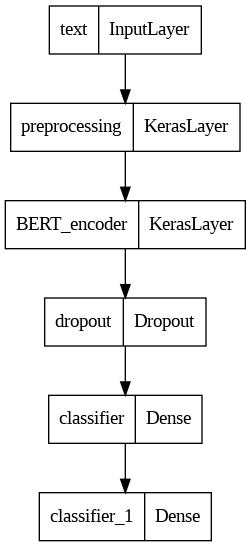

In [44]:
tf.keras.utils.plot_model(classifier_model)

# loss function


In [45]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

optimizer

In [46]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Loading the BERT model and training

In [47]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [48]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
658/658 [==============================] - 823s 1s/step - loss: 0.5133 - binary_accuracy: 0.7360 - val_loss: 0.3875 - val_binary_accuracy: 0.8366
Epoch 2/10
658/658 [==============================] - 808s 1s/step - loss: 0.3868 - binary_accuracy: 0.8245 - val_loss: 0.2855 - val_binary_accuracy: 0.8939
Epoch 3/10
658/658 [==============================] - 806s 1s/step - loss: 0.2647 - binary_accuracy: 0.8916 - val_loss: 0.1387 - val_binary_accuracy: 0.9514
Epoch 4/10
658/658 [==============================] - 804s 1s/step - loss: 0.1516 - binary_accuracy: 0.9455 - val_loss: 0.0750 - val_binary_accuracy: 0.9732
Epoch 5/10
658/658 [==============================] - 803s 1s/step - loss: 0.0909 - binary_accuracy: 0.9695 - val_loss: 0.0491 - val_binary_accuracy: 0.9858
Epoch 6/10
658/658 [==============================] - 846s 1s/step - loss: 0.0657 - binary_accuracy: 0.9799 - val_loss: 0.0261 - val

Evaluate the model

In [49]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

81/81 [==============================] - 26s 321ms/step - loss: 1.8120 - binary_accuracy: 0.7866
Loss: 1.8120037317276
Accuracy: 0.786630392074585


5 epochs, accuracy : 0.79
10 epochs, accuracy: 0.78

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


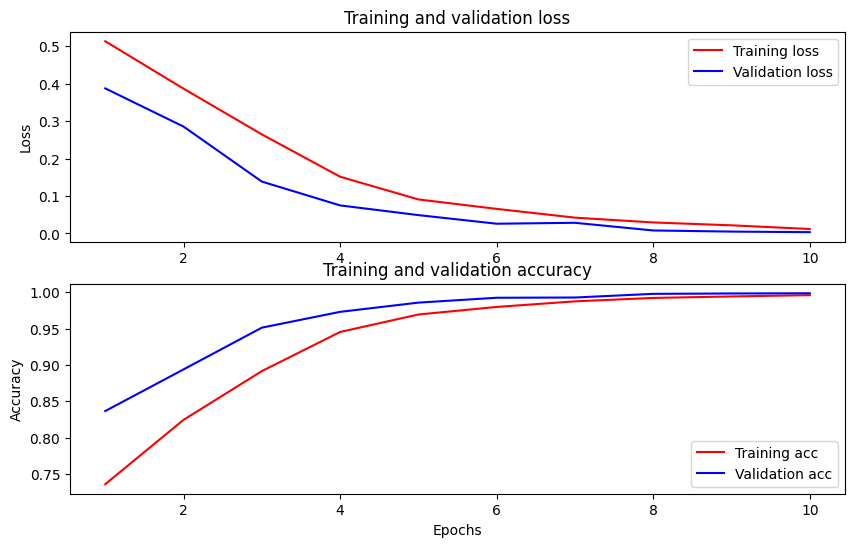

In [50]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Test results:
With **Small Bert model small_bert/bert_en_uncased_L-4_H-512_A-8**
learn_rate = 1e-5, Dropout = 0.1
5 epochs, accuracy : 0.79
10 epochs, accuracy: 0.78

The validation score and training scores in 5epochs are both in increase trend,
which means there aren't any overfitting occur at the moment. As to maximize the model potential, I also increase the epoch number to 10.

Also, I switched learing_rate rate from 1e-5 to 3e-5 as the tutorial suggests, start with the smaller one for fine-tuning.

learn_rate = 3e-5, Dropout = 0.1
5 epochs, Loss: 1.303869605064392, accuracy: 0.7839098572731018.
10 epochs,  Loss: 0.8732767701148987, accuracy: 0.79


learning rate = 3e-5, Dropout = 0.5
10 epoch
Loss: 0.8810169696807861
Accuracy: 0.7835211753845215

Change of dropout rate from 0.1 to 0.5 trying to prevent overfitting. It means an increase in regularization as well. However, it doesn't reflect an increase in the accuracy score in this case. The accruacy with other hyperparameters remains, even dropped a bit after switching the drop-out rate.

Last try with BERT_en_uncased
With an extra hidden layer, and 10epoch
The output is only up to Loss: 1.8120037317276
Accuracy: 0.786630392074585.

These are not anything higher than the origianl model setting.



So far, after many random tryouts, the best output is still cooming from the smallerBert model with default setting learning_rate 3e-5, dropout= 0.1, 5epochs. The accruacy was above 0.79.